# Import

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [21]:
df = pd.read_csv('Data/london_merged.csv')
display(df.head(2))

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0


- Metadata:
  - "timestamp" - timestamp field for grouping the data
  - "cnt" - the count of a new bike shares
  - "t1" - real temperature in C
  - "t2" - temperature in C "feels like"
  - "hum" - humidity in percentage
  - "wind_speed" - wind speed in km/h
  - "weather_code" - category of the weather
  - "is_holiday" - boolean field - 1 holiday / 0 non holiday
  - "is_weekend" - boolean field - 1 if the day is weekend
  - "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
  - "weathe_code" category description:
     - 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
     - 2 = scattered clouds / few clouds 
     - 3 = Broken clouds 
     - 4 = Cloudy 
     - 7 = Rain/ light Rain shower/ Light rain 
     - 10 = rain with thunderstorm 
     - 26 = snowfall 
     - 94 = Freezing Fog

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# Data Wrangling

In [23]:
#Convert the timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
#Set the timestamp as the index
df.set_index('timestamp', inplace=True)
#Set period to 1 hour
df.index = pd.DatetimeIndex(df.index).to_period('h')
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [24]:
#Missing values
df.isnull().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

- No missing values

In [25]:
#Remove duplicates
df.drop_duplicates(inplace=True)

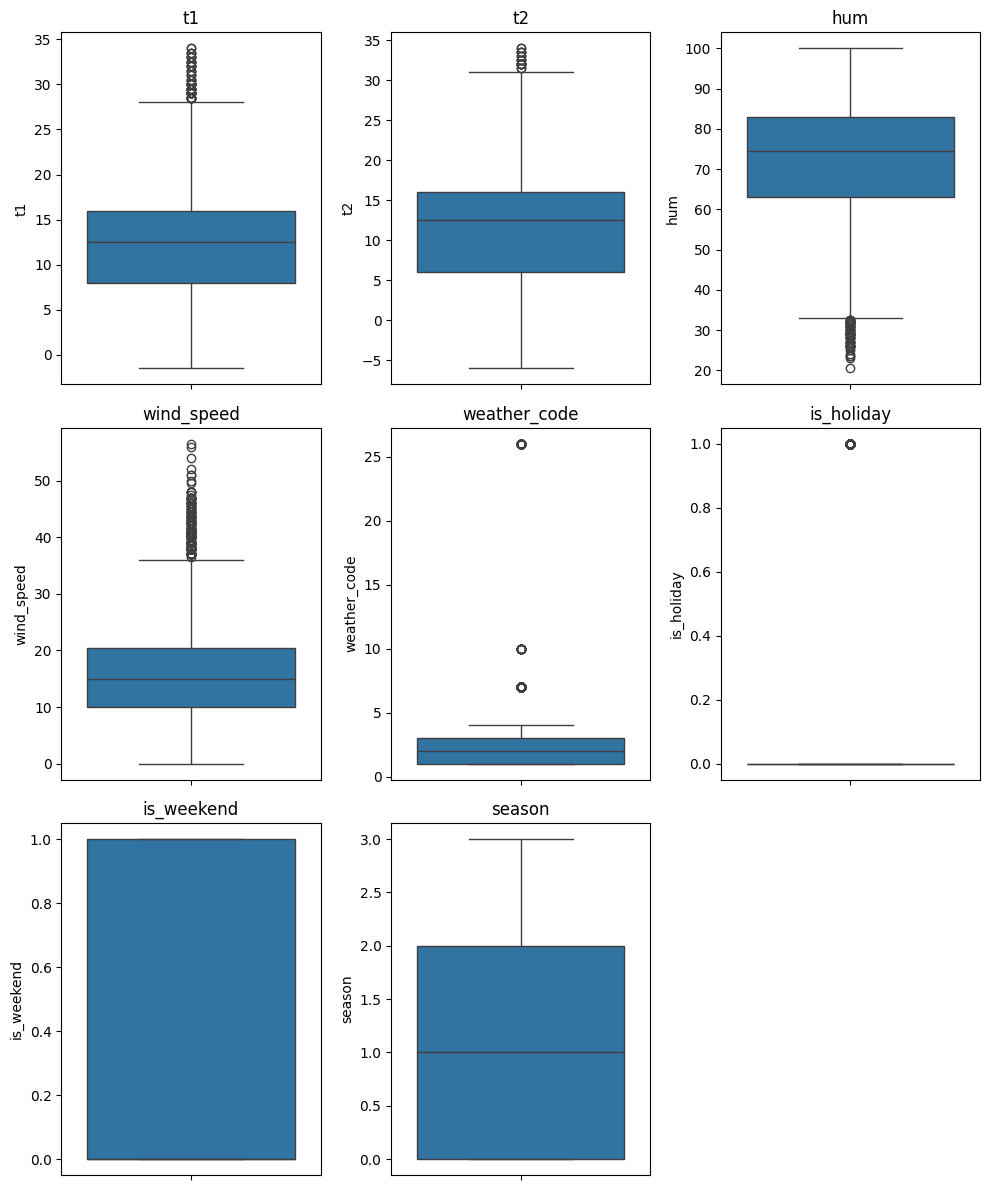

In [26]:
# Boxplot of all the columns
plt.figure(figsize=(10, 12))
cols = df.columns
for i in range(1, len(cols)):
    plt.subplot(3, 3, i)
    sns.boxplot(df[cols[i]])
    plt.title(cols[i])
plt.tight_layout()
plt.show()

- There is no abnormal data in the dataset.

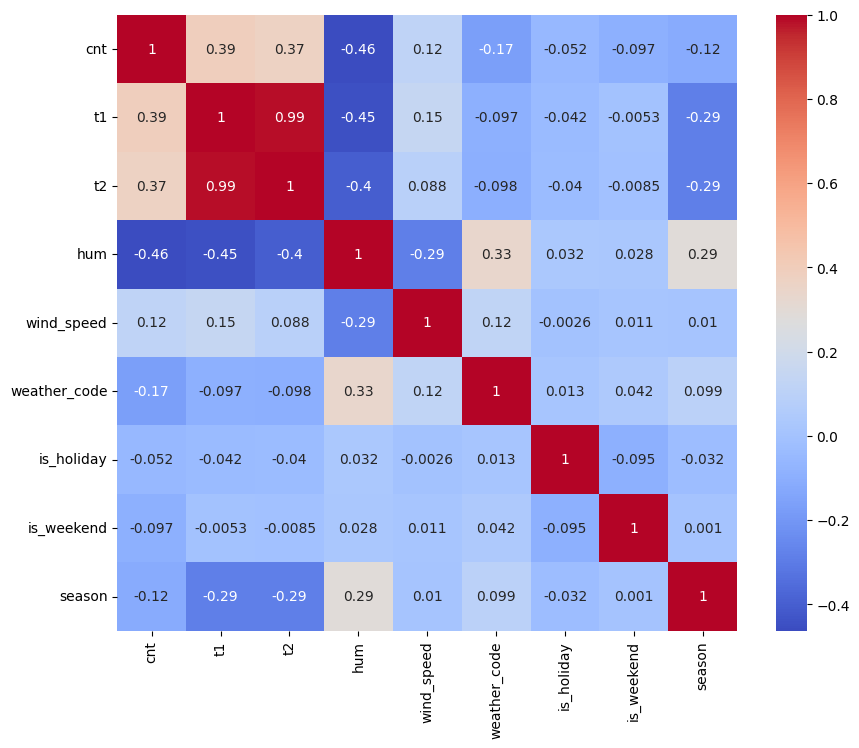

In [27]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

- Real and feels like temperature are highly correlated. Let's use feels like temperature since it is more likely to impact the decision.

In [28]:
#Drop t1
df.drop('t1', axis=1, inplace=True)

In [29]:
#Map codes
#Map weather code:
weather_desc = {
    1: 'Clear', 2: 'Scattered_Clouds', 3: 'Broken_Clouds', 4: 'Cloudy', 7: 'Rain', 10: 'Storm', 26: 'Snowfall', 94: 'Freezing_Fog'
}
df['weather_code'] = df['weather_code'].map(weather_desc)

#Map is_holiday:
df['is_holiday'] = df['is_holiday'].map({0:'No_Holiday', 1:'Holiday'})

#Map is_weekend:
df['is_weekend'] = df['is_weekend'].map({0:'Weekday', 1:'Weekend'})

#Map season:
seasons = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
df['season'] = df['season'].map(seasons)
df.head(2)

,cnt,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,
2015-01-04 00:00,182,2.0,93.0,6.0,Broken_Clouds,No_Holiday,Weekend,Winter
2015-01-04 01:00,138,2.5,93.0,5.0,Clear,No_Holiday,Weekend,Winter


In [30]:
#One hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True, dtype=int)
df.head(2)

,cnt,t2,hum,wind_speed,weather_code_Clear,weather_code_Cloudy,weather_code_Rain,weather_code_Scattered_Clouds,weather_code_Snowfall,weather_code_Storm,is_holiday_No_Holiday,is_weekend_Weekend,season_Spring,season_Summer,season_Winter
timestamp,,,,,,,,,,,,,,,
2015-01-04 00:00,182,2.0,93.0,6.0,0,0,0,0,0,0,1,1,0,0,1
2015-01-04 01:00,138,2.5,93.0,5.0,1,0,0,0,0,0,1,1,0,0,1


In [31]:
#Split the data into train and test
X = df.drop('cnt', axis=1)
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

#Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models

## SARIMAX

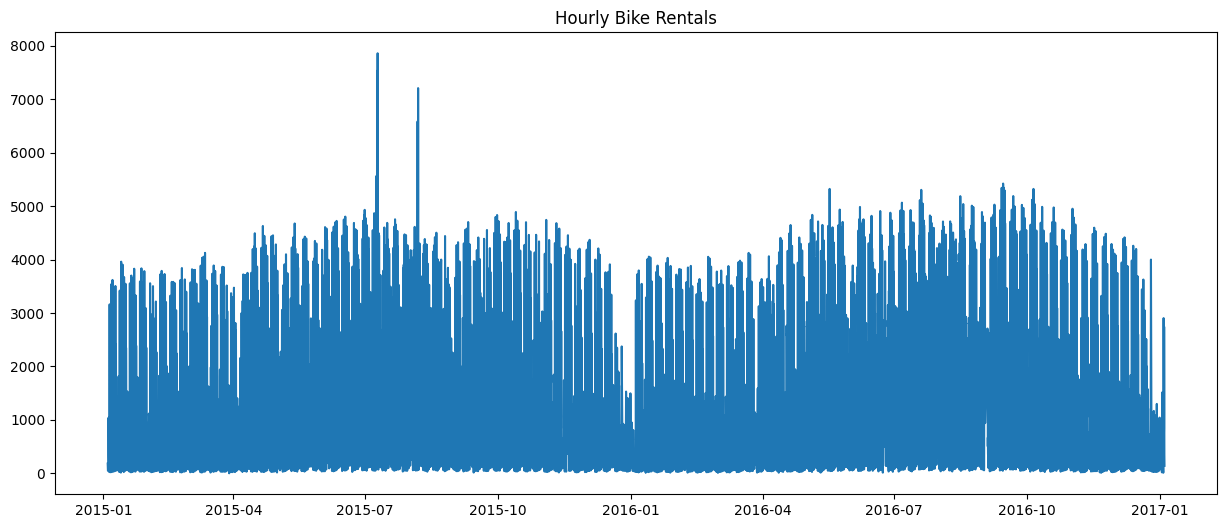

ADF Statistic: -9.8780969758485
p-value: 3.83428844717726e-17
Critical Values: {'1%': -3.4307265265769766, '5%': -2.861706410125867, '10%': -2.566858575804007}
Data is stationary


In [32]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller

#Plot to check for stationarity
plt.figure(figsize=(15, 6))
plt.plot(y.to_timestamp())
plt.title('Hourly Bike Rentals')
plt.show()


def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print('Data is not stationary')
    else:
        print('Data is stationary')

#Check stationarity of the target variable
check_stationarity(y)